# 1. Digit Recognizer

## a. Parsing the data

In [2]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
data = pd.read_csv("./DigitRecognizer/train.csv")
data_test = pd.read_csv("./DigitRecognizer/test.csv")

Y = data.label
X = data[data.columns[1:]]


## b. Displaying digits

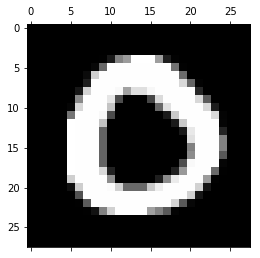

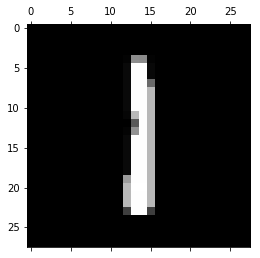

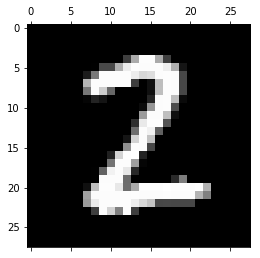

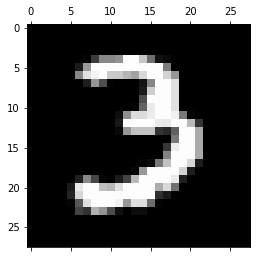

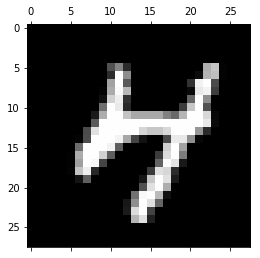

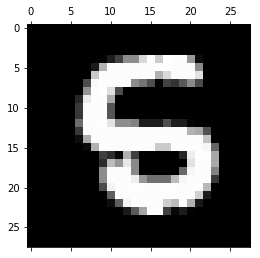

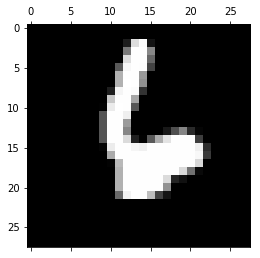

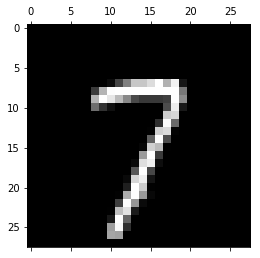

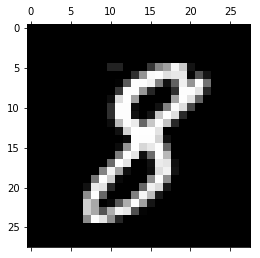

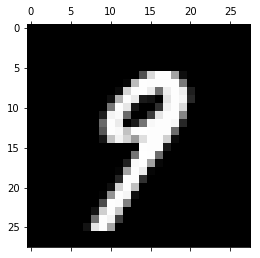

In [3]:
digits = [0,1,2,3,4,5,6,7,8,9]
digits_idx = []
for digit in digits:
    idx = Y[Y == digit].index.tolist()[1]
    digits_idx.append(X.loc[idx])
    plt.matshow(X.loc[idx].values.reshape(28,28), cmap='gray')

## c. Prior Probability & Histogram

In [4]:
for digit in digits:
    digitCount = len(Y[Y == digit].index.tolist())
    print("Prior probability for Label:", digit, " is ", digitCount/42000.0 )
    

Prior probability for Label: 0  is  0.09838095238095237
Prior probability for Label: 1  is  0.11152380952380953
Prior probability for Label: 2  is  0.09945238095238096
Prior probability for Label: 3  is  0.1035952380952381
Prior probability for Label: 4  is  0.09695238095238096
Prior probability for Label: 5  is  0.09035714285714286
Prior probability for Label: 6  is  0.0985
Prior probability for Label: 7  is  0.10478571428571429
Prior probability for Label: 8  is  0.09673809523809523
Prior probability for Label: 9  is  0.09971428571428571


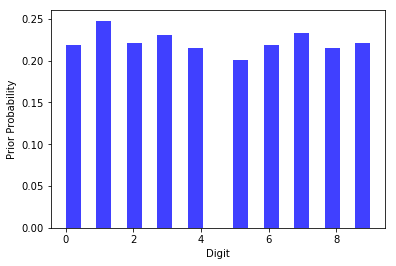

In [5]:
plt.hist(Y,20,normed=1, facecolor='blue', alpha=0.75)
plt.xlabel("Digit")
plt.ylabel("Prior Probability")

## d. L2 distance

In [6]:
nparray = np.array(digits_idx)
L2_dist = cdist( nparray, X, 'euclidean')
for digit in digits:
    idx = np.argpartition(L2_dist[digit], 2)[1]
    print("Expected Label : ", digit, "|| Distance :",L2_dist[digit][idx]," || Actual Label : ", Y[idx])

Expected Label :  0 || Distance : 1177.09770198  || Actual Label :  0
Expected Label :  1 || Distance : 441.011337723  || Actual Label :  1
Expected Label :  2 || Distance : 1031.24342422  || Actual Label :  2
Expected Label :  3 || Distance : 1392.96159315  || Actual Label :  3
Expected Label :  4 || Distance : 1353.19843334  || Actual Label :  4
Expected Label :  5 || Distance : 1646.02095977  || Actual Label :  5
Expected Label :  6 || Distance : 1078.31859856  || Actual Label :  6
Expected Label :  7 || Distance : 761.583219353  || Actual Label :  7
Expected Label :  8 || Distance : 1074.0460884  || Actual Label :  8
Expected Label :  9 || Distance : 791.490998054  || Actual Label :  9


## e. Binary comparison : digits 0 and 1

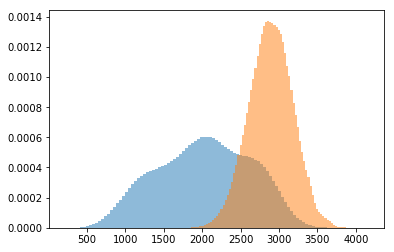

In [8]:
#zero_data = data[data.label == 0]
#one_data = data[data.label == 1]
#L2_dist_genuine_zero = cdist( zero_data, zero_data, 'euclidean')
#L2_dist_genuine_one = cdist( one_data, one_data, 'euclidean')
#L2_dist_imposter = cdist( zero_data, one_data, 'euclidean')

from sklearn import metrics
zeroone = data
for i in range(2, 10):
    zeroone = zeroone[zeroone.label != i]
zeroone = zeroone.sort_values(by='label')
zeros = zeroone[zeroone.label != 1]
ones = zeroone[zeroone.label !=0 ]
genuine = []
countzero, countone = zeroone['label'].value_counts()
distanceMatrixZero = metrics.pairwise.pairwise_distances(zeros,Y=None,metric='euclidean',n_jobs=1)
distanceMatrixOne = metrics.pairwise.pairwise_distances(ones,Y=None,metric='euclidean',n_jobs=1)
distanceMatrixZeroOne = metrics.pairwise.pairwise_distances(zeros,ones,metric='euclidean',n_jobs=1)
genuine = np.append(distanceMatrixZero[np.triu_indices(zeros.shape[0])], distanceMatrixOne[np.triu_indices(ones.shape[0])])
imposter = distanceMatrixZeroOne[np.triu_indices(countzero,k=0,m=countone)]

fig, ax = plt.subplots()
genuine = genuine[np.nonzero(genuine)]
genuine_axis = ax.hist(genuine, bins=100,normed=1, alpha=0.5,label='genuine')
impostor_axis = ax.hist(imposter,bins=100,normed=1,alpha=0.5,label='imposter')
#plt.legend(handles=[genuine_axis, impostor_axis])
plt.show()

## f. ROC Curve

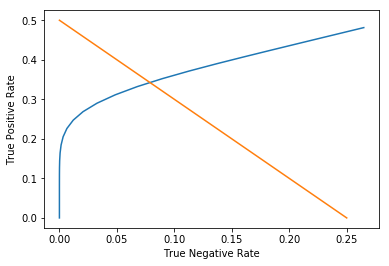

In [30]:
tp=0
fn=0
tn=0
fp=0
tpr=[]
tnr=[]
for t in range(0,4000,100):
    for value in genuine:
        if value <=t:
            tp+=1
        else:
            fn+=1
    for value in imposter:
        if value<=t:
            tn+=1
        else:
            fp+=1
    tpr.append(tp/(tp+fn))
    tnr.append(tn/(tn+fp))
    
plt.plot(tnr, tpr)
plt.plot([.25,0],[0,0.5]) #rough estimate of diagonal
plt.xlabel("True Negative Rate")
plt.ylabel("True Positive Rate")
plt.show()


## g. kNN classifier

In [21]:
from scipy.stats import mode
from sklearn.metrics import classification_report
import bottleneck as bn

def kNN(test, train, k,train_flag):
    n_test = np.array(test)
    n_train = np.array(train)
    if(train_flag == True):
        L2_dist_kNN = cdist(n_test , n_train , 'euclidean') 
    else:
        df = train[train.columns[1:]]
        L2_dist_kNN = cdist(n_test , np.array(df) , 'euclidean')
    print('L2_shape: ', L2_dist_kNN.shape)
    c = 0
    train_pred =[]
    test_label = []
    for row in L2_dist_kNN:
        array_idx = np.argsort(row)
        elems = []
        elems.append(n_train[array_idx[0]][0])
        elems.append(n_train[array_idx[1]][0])
        elems.append(n_train[array_idx[2]][0])
        elems.append(n_train[array_idx[3]][0])
        elems.append(n_train[array_idx[4]][0])
        train_pred.append(mode(elems)[0][0])
        if(train_flag == True):
            test_label.append(n_test[c][0])
            c += 1
    if(train_flag == True):
        print(classification_report(test_label,train_pred))  
        return test_label,train_pred
    else:
        return train_pred




In [26]:
from sklearn.model_selection import KFold
all_test_table = []
all_train_pred = []
for train, test in KFold(n_splits=3).split(data):
    test_label, train_pred = kNN(data.loc[test],data.loc[train],5,True) 
    all_test_table.append(test_label)
    all_train_pred.append(train_pred)

L2_shape:  (14000, 28000)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1371
          1       0.94      0.99      0.97      1575
          2       0.98      0.95      0.97      1427
          3       0.95      0.97      0.96      1410
          4       0.98      0.96      0.97      1368
          5       0.96      0.95      0.96      1276
          6       0.97      0.99      0.98      1399
          7       0.96      0.96      0.96      1464
          8       0.99      0.91      0.95      1343
          9       0.94      0.96      0.95      1367

avg / total       0.96      0.96      0.96     14000

L2_shape:  (14000, 28000)
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1350
          1       0.95      0.99      0.97      1532
          2       0.98      0.95      0.96      1397
          3       0.95      0.96      0.95      1499
          4       0.97      0.96      0.97 

## i. Confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(all_test_table[0], all_train_pred[0])
cm2 = confusion_matrix(all_test_table[1], all_train_pred[1])
cm3 = confusion_matrix(all_test_table[2], all_train_pred[2])
cm1+cm2+cm3


array([[4104,    1,    4,    0,    0,    7,   12,    2,    0,    2],
       [   0, 4660,    9,    2,    1,    0,    2,    7,    1,    2],
       [  34,   59, 3966,   13,    3,    5,    3,   83,    8,    3],
       [   5,   13,   28, 4193,    0,   43,    1,   24,   24,   20],
       [   2,   50,    0,    0, 3905,    0,   14,    7,    2,   92],
       [  11,    9,    2,   73,    3, 3619,   48,    3,    4,   23],
       [  26,    7,    1,    0,    4,   17, 4081,    0,    1,    0],
       [   2,   61,   11,    3,   13,    0,    0, 4265,    0,   46],
       [  19,   50,   20,   77,   22,   79,   20,   13, 3720,   43],
       [  16,   13,    3,   33,   47,   11,    1,   69,   11, 3984]])

## j. Train kNN classifier with all training data & test with test data

In [12]:
label_pred = kNN(data_test, data, 5,False)
print('Predictions done.')

L2_shape:  (28000, 42000)
Predictions done.


In [31]:
predictions = pd.DataFrame({'Label': label_pred})
predictions.index+=1
predictions.index
predictions.to_csv('./DigitRecognizer/submission.csv')